In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import math
from matplotlib.ticker import MaxNLocator

import math
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

def get_maxK_above_prob(target_prob, p=0.01 + 1/12, L=10**3):

    best_K = None
    for K in range(2, L, 2):
        x_min = math.floor((K+1) / 2)
        current_prob = binom.sf(x_min - 1, K, p)  # P(X >= x_min)
        if current_prob > target_prob:
            best_K = K
        else:
            break
    return best_K


In [5]:


def min_q(t,eps):
    
    def cost(q,t,eps):
        """\
        if q is too small, this cost is positive
        """
        q = float(q)
        t = float(t)

        log_q_fact = q*np.log(q)-q
        return np.log(4)+q*np.log(t)-q*np.log(2)-log_q_fact - np.log(eps) 
    
    query = int(t)
    query_low = int(t)

    while True:
        query = 2*query
        if cost(query,t,eps) < 0:
            break
    
    query_upp = copy.deepcopy(query)
    
    while True:
        query_mid = int(np.ceil((query_upp+query_low)/2))

        if cost(query_mid,t,eps) >= 0:
            query_low = query_mid
        else:
            query_upp = query_mid
            
        if query_mid == int(np.ceil((query_upp+query_low)/2)):
            break
    
    return int(np.ceil((query_upp+query_low)/2))

def lem8_sp_query(q,M,qubits):
    p = 3
    eps_double = 2**(-14)
    delta = 2**(-10)
    sigma = int(np.ceil(np.sqrt(2*M*(qubits*np.log(2)+np.log(2/delta)))))
    t = (2**(p+q+2))*sigma
    
    query = 4*(-1+min_q(t,eps_double/8))
    
    return query

def imp_sp_query_sym(q, N, eta, k, target_precision, c):
    p = 3
    eps_double = 2**(-14)
    v =  0.1652
    norm = 2*math.comb(eta, k) * math.comb((N-eta +k ), k ) - math.comb(N, k) * math.comb(N - 2*k , eta- k) / math.comb(N, eta)
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))

    sigma =  int(np.ceil(np.sqrt(2 *  v *  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 
    
    t = (2**(p+q) * 2  )*sigma

    prob = 0.011 + 1/12
    L = 1000
    rep = get_maxK_above_prob(errp/M, p=prob, L=L)

    query = 2*(-1+min_q(t,eps_double/8)) * rep
    
    return query


def imp_sp_query_int(q, N, eta, k, target_precision, c):
    p = 3
    eps_double = 2**(-14)
    v =  0.1652
    norm = 2*math.comb(eta, k) * math.comb((N-eta +k ), k ) - math.comb(N, k) * math.comb(N - 2*k , eta- k) / math.comb(N, eta)
    M = math.comb(N, k) ** 2
    delta = 2**(-10)
    dim = math.comb(N, eta)
    eps_double = 2**(-14)

    delta = 2**(-10)
    
    errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
    Error =  errp/2

    delta = min( Error**2 / 20, delta)
    eps_double = min(eps_double, Error**2 / 2**6)

    prob = 0.011
    L = 1000
    rep = get_maxK_above_prob(errp/(2*M), p=prob, L=L)

    sigma = int(np.ceil(np.sqrt(2 *  v * rep*  norm *(np.log(2*dim /delta) )  ) + 4/3 *np.log(2*dim /delta) ) ) 

    
    t = (2**(p+q) * 2  )*sigma

    query = 2*(-1+min_q(t,eps_double/8))
    
    return query



In [7]:

f = 10
def total_query(target_precision, N, eta, k, c=3/(8*((1+np.pi)**2))):
    M = math.comb(N,k) **2
    qubits = N
    tot_query = 0
    for q in range(int(np.ceil(np.log2(1/target_precision)))+1):
        errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += int(np.ceil(9*np.log(M/errp)))*lem8_sp_query(q,M,qubits)
        
    return tot_query


def imp_total_query_sym(target_precision, N, eta, k,  c=1/(f*8*((1+np.pi)**2))):
    tot_query = 0
    a = 1/np.sqrt(1/4 + 1/(4*f) )
    for q in range(int(np.ceil(np.log2(1/target_precision /a )))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_sym(q, N, eta, k, a* target_precision, c)
        
    return tot_query

def imp_total_query_int(target_precision, N, eta, k,  c=1/(f*8*((1+np.pi)**2))):
    tot_query = 0
    a = 1/np.sqrt(1/4 + 1/(4*f) )
    for q in range(int(np.ceil(np.log2(1/target_precision / a)))+1):
        # errp = c/(8**(int(np.ceil(np.log2(1/target_precision)))-q))
        tot_query += imp_sp_query_int(q, N, eta, k, a*target_precision, c)
        
    return tot_query


def HL_QAE2(target_precision,  N, eta, k):  
    target_precision  = int(np.ceil(math.log2(math.pi/(target_precision))))
    M = math.comb(N, k) ** 2
    single_obs = 2**(target_precision) + 1
    return  single_obs*M

def normal_kRDM_CS(target_precision,  N, eta, k) :
    M = math.comb(N, k) ** 2
    c = 1 + (2 * math.log(4*M/ target_precision**2 ) )**(-1)
    # pre1 = math.comb(N, k)
    # pre2 = math.sqrt(math.pi * k )

    shadow = math.comb(2*N, 2*k)/ math.comb(N, k )
    query = shadow/ target_precision**2

    return int(np.ceil(query))
    

In [ ]:
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント


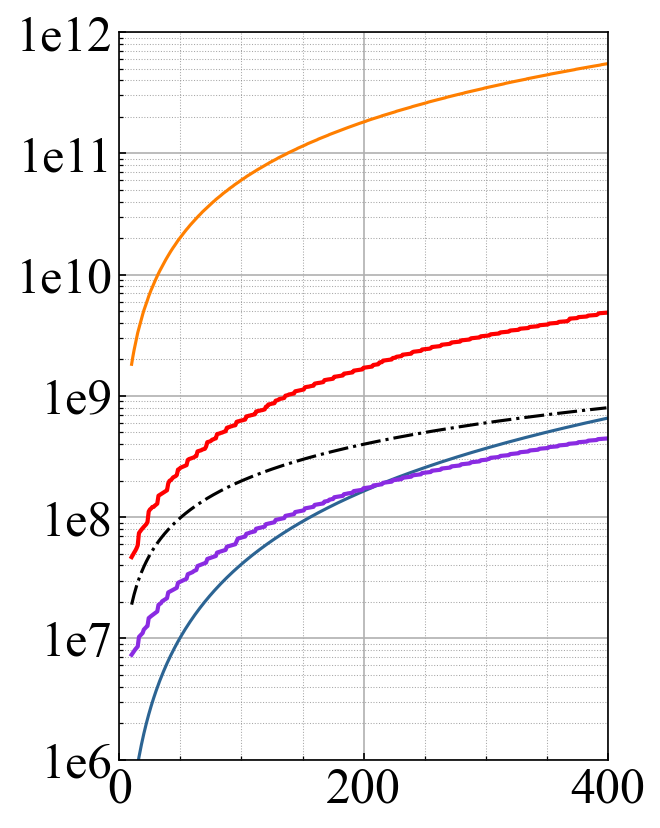

In [ ]:
dpi = 150

a = 1.4
a = 1.4
fig, ax = plt.subplots(figsize=(a*3, a*4.5), dpi=dpi) #main text 
plt.rcParams["font.size"] = 24


k = 1

num_particle =  113 #int(qubits * 7/8)

num_qubits = [r for r in range(10, 400, 1)]
etas = [int(math.ceil(r* 7/8)) for r in range(10, 400, 1)]
target_precision = 10**-3.


a=1
if a == 1:
    tot_query = [ total_query(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    sym_tot_query = [imp_total_query_sym(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    int_tot_query = [imp_total_query_int(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    tot_query_HLQAE = [HL_QAE2(target_precision, num_qubits[i], etas[i],k ) for i in range(len(num_qubits))]
    tot_query_CS = [normal_kRDM_CS(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]

ax.plot(num_qubits, tot_query_CS,    color="#000000", linestyle="-.", label="Fermionic shadow")      # 紫 (暗め)
ax.plot(num_qubits, sym_tot_query,  color="red", linewidth = 2,label="Method I (ours)")  # 青 (暗め)
ax.plot(num_qubits,tot_query_HLQAE, color="#2C6493", linewidth = 1.5,   label="HL QAE (ours)")
ax.plot(num_qubits, int_tot_query,  color="#8A2BE2", linewidth = 2,label="Method II (ours)")
ax.plot(num_qubits, tot_query,       color="#FF7F00", linewidth = 1.5, label="Previous QGE")


ax.set_yscale("log")
ax.set_xscale("linear")


ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, _: f'1e{int(np.log10(y))}' if y > 0 else ''))

ax.set_xlim([0, 400])
ax.set_ylim([10**(6), 10**12])
ax.minorticks_on()

ax.grid(linestyle = 'solid', linewidth = 0.5)
ax.grid(which="minor", color="lightgray", linestyle="dotted")
ax.grid(which="minor", color="gray", linestyle=":", linewidth=0.5, alpha=0.7)
ax.grid(which="major", linestyle="solid", linewidth=0.8)

plt.show()
                                       

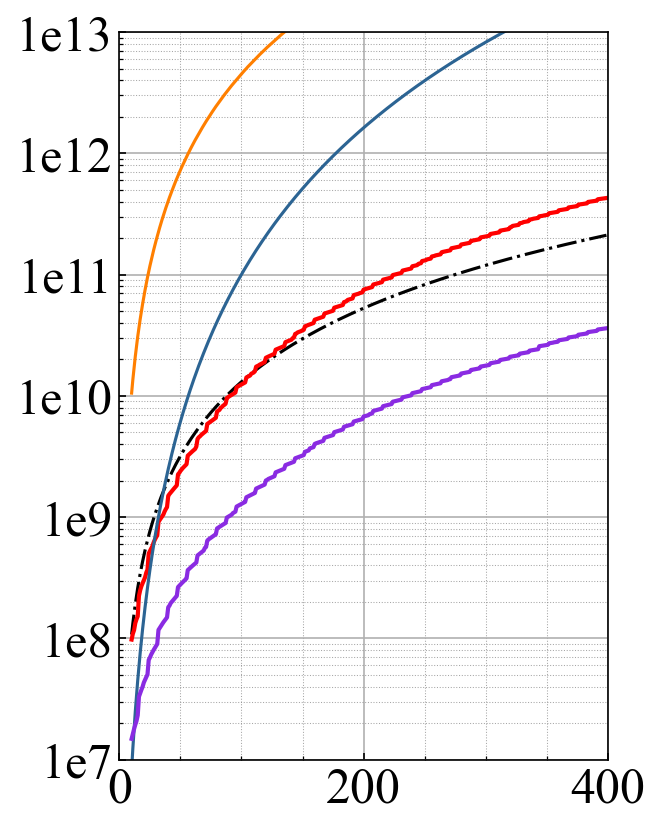

In [23]:
dpi = 150

a = 1.4
a = 1.4
fig, ax = plt.subplots(figsize=(a*3, a*4.5), dpi=dpi) #main text 
plt.rcParams["font.size"] = 24


k = 2

num_particle =  113 #int(qubits * 7/8)

num_qubits = [r for r in range(10, 400, 1)]
etas = [int(math.ceil(r* 7/8)) for r in range(10, 400, 1)]
target_precision = 10**-3.


a=1
if a == 1:
    tot_query = [ total_query(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    sym_tot_query = [imp_total_query_sym(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    int_tot_query = [imp_total_query_int(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]
    tot_query_HLQAE = [HL_QAE2(target_precision, num_qubits[i], etas[i],k ) for i in range(len(num_qubits))]
    tot_query_CS = [normal_kRDM_CS(target_precision, num_qubits[i], etas[i], k) for i in range(len(num_qubits))]

ax.plot(num_qubits, tot_query_CS,    color="#000000", linestyle="-.", label="Fermionic shadow")      # 紫 (暗め)
ax.plot(num_qubits, sym_tot_query,  color="red", linewidth = 2,label="Method I (ours)")  # 青 (暗め)
ax.plot(num_qubits,tot_query_HLQAE, color="#2C6493", linewidth = 1.5,   label="HL QAE (ours)")
ax.plot(num_qubits, int_tot_query,  color="#8A2BE2", linewidth = 2,label="Method II (ours)")
ax.plot(num_qubits, tot_query,       color="#FF7F00", linewidth = 1.5, label="Previous QGE")


ax.set_yscale("log")
ax.set_xscale("linear")


ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, _: f'1e{int(np.log10(y))}' if y > 0 else ''))

ax.set_xlim([0, 400])
ax.set_ylim([10**(7), 10**13])
ax.minorticks_on()

ax.grid(linestyle = 'solid', linewidth = 0.5)
ax.grid(which="minor", color="lightgray", linestyle="dotted")
ax.grid(which="minor", color="gray", linestyle=":", linewidth=0.5, alpha=0.7)
ax.grid(which="major", linestyle="solid", linewidth=0.8)

plt.show()
                                       